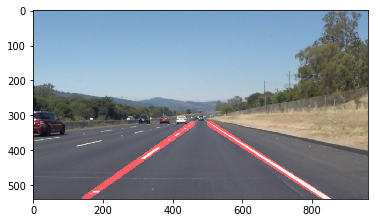

In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
image = mpimg.imread('test_images/solidWhiteRight.jpg')

gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # converts the image into gray scale
gaussian_img = cv2.GaussianBlur(gray_img, (5, 5), 0) # output the gray image with gaussian blur
canny_img = cv2.Canny(gaussian_img, 40, 150) # Canny function from cv2 is applied to detect edges from the image

# defining the useful part of image which doesnot include the upper 60% of the image because the roads are below that
height = canny_img.shape[0]
width = canny_img.shape[1]
upper_half = height*.6
ratio = 4/7
vertices = np.array([[(20,height),((1-ratio)*width, upper_half),(ratio*width, upper_half), (width-20,height)]], dtype=np.int32)
mask = np.zeros_like(canny_img)
if len(canny_img.shape) > 2:
    channel_count = canny_img.shape[2]  
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255  
cv2.fillPoly(mask, vertices, ignore_mask_color)

masked_img = cv2.bitwise_and(canny_img, mask) # this is the final image which is masked to get the lower part of the image

lines = cv2.HoughLinesP(masked_img, 3, np.pi/180, 95 ,minLineLength=30, maxLineGap= 22) # this extracts lines from the masked image using Hough TF
line_img = np.zeros((masked_img.shape[0], masked_img.shape[1], 3), dtype=np.uint8)

color=[255, 0, 0]
thickness=15
left_slope = []
left_intercept = []

right_slope = []
right_intercept = []

y_min = y_max = line_img.shape[0]

for line in lines:
    for x1,y1,x2,y2 in line:
        slope = (y2-y1)/(x2-x1)
        if(slope >= 0):
            right_slope.append(slope)
            right_intercept.append(y1 - slope*x1)
        else:
            left_slope.append(slope)
            left_intercept.append(y1 - slope*x1)

        y_min = min(y_min, y1, y2)
        
def get_x_point(point, intercept, slope):
    return int((point - intercept)/slope)

if right_slope and right_intercept:
    right_slope = np.mean(right_slope)
    right_intercept = np.mean(right_intercept)
    right_x_min = get_x_point(y_min, right_intercept, right_slope)
    right_x_max = get_x_point(y_max, right_intercept, right_slope)
    cv2.line(line_img, (right_x_min, y_min), (right_x_max, y_max), color, thickness)

if left_slope and left_intercept:
    left_slope = np.mean(left_slope)
    left_intercept = np.mean(left_intercept)
    left_x_min = get_x_point(y_min, left_intercept, left_slope)
    left_x_max = get_x_point(y_max, left_intercept, left_slope)
    cv2.line(line_img, (left_x_min, y_min), (left_x_max, y_max), color, thickness)

α=0.8
β=1.
λ=0.
wtimg = cv2.addWeighted(line_img, α, image, β, λ)

plt.imshow(wtimg, 'gray')
plt.show()

# white_output = 'test_videos_output/solidWhiteRight.mp4'

# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
# white_clip = clip1.fl_image(wtimg) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)